## 1. Carga de librerias, modelos y herramientas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [2]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

In [3]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_touch215.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_humidity = pretreat_data_df(df_test, 'humidity')
df_co2 = pretreat_data_df(df_test, 'CO2')

len(df_temperature), len(df_humidity), len(df_co2)

(112534, 147229, 160296)

In [4]:
df_temperature.head()

,temperature
timestamp,
2023-03-03 09:31:00,16.9
2023-03-03 09:32:00,16.8
2023-03-03 09:36:00,17.0
2023-03-03 09:37:00,17.3
2023-03-03 09:38:00,17.5


In [5]:
df_co2.head()

,CO2
timestamp,
2023-03-03 09:30:00,615.04
2023-03-03 09:31:00,613.12
2023-03-03 09:32:00,616.96
2023-03-03 09:33:00,624.00
2023-03-03 09:34:00,624.96


In [6]:
df_humidity.head()

,humidity
timestamp,
2023-03-03 09:31:00,31.5
2023-03-03 09:33:00,31.7
2023-03-03 09:34:00,32.1
2023-03-03 09:35:00,31.9
2023-03-03 09:36:00,32.9


In [7]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Touch 215 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Touch 215 ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2023-03-05'])
    plt.title('1 day Touch 215 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

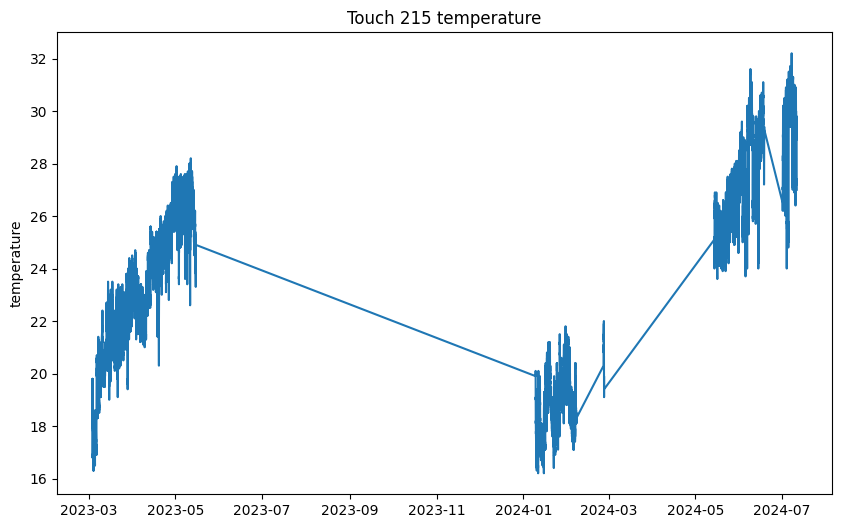

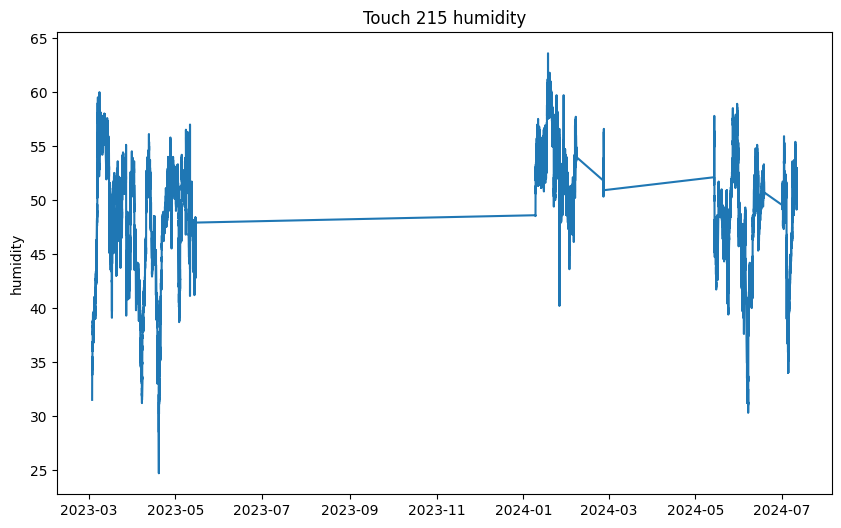

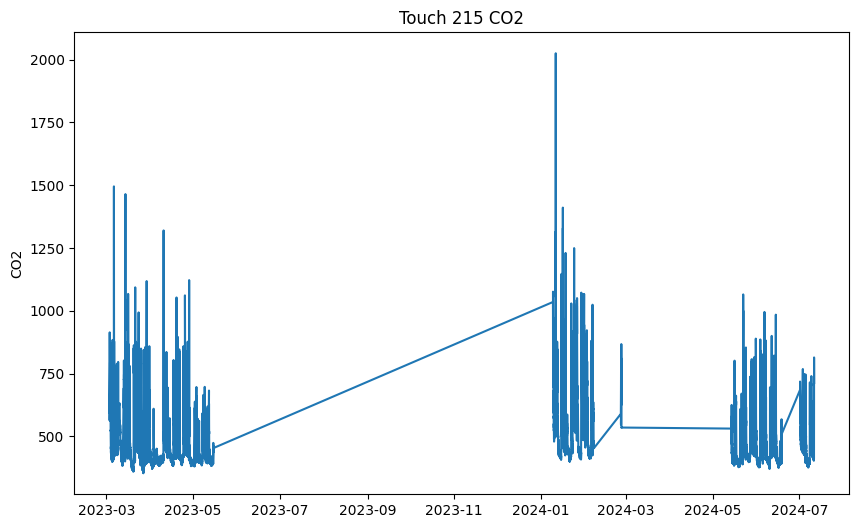

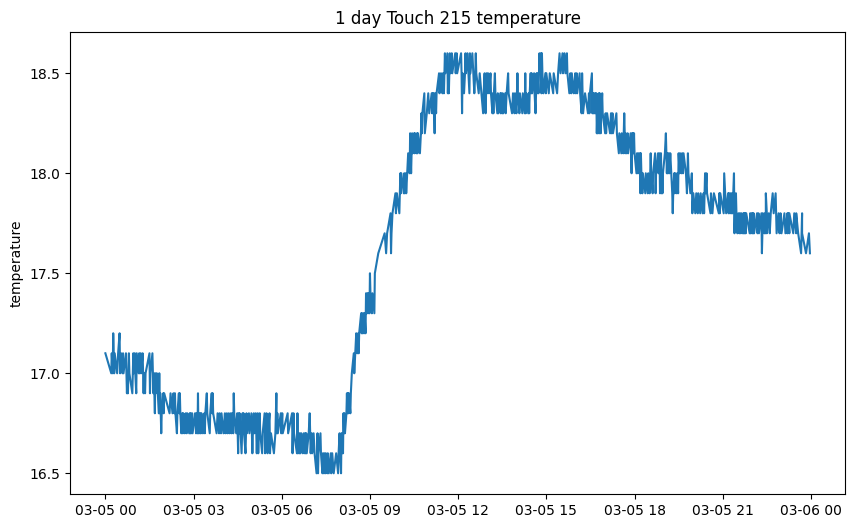

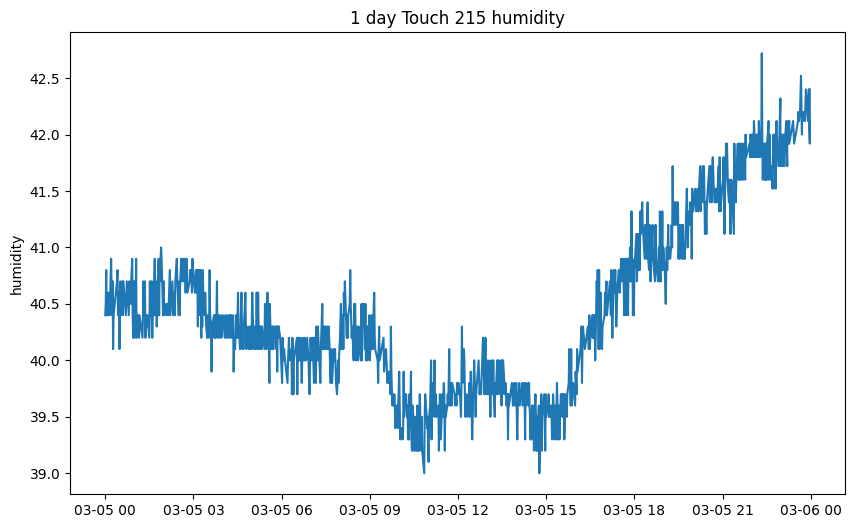

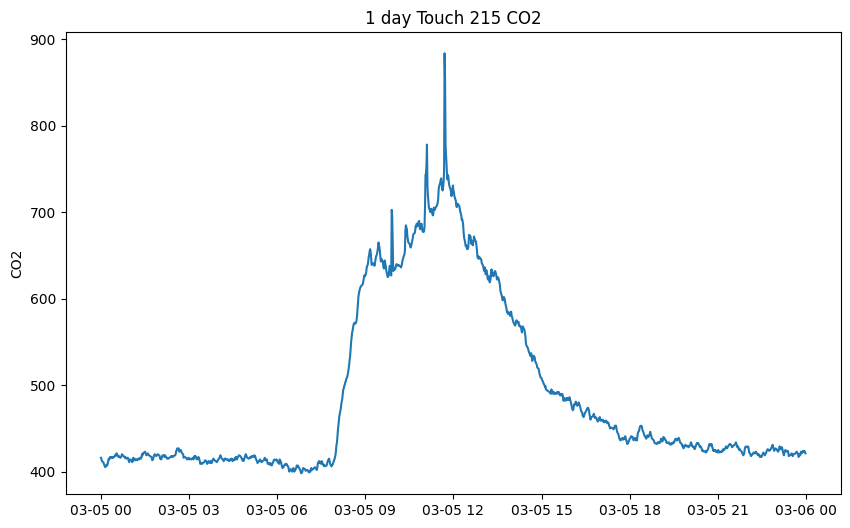

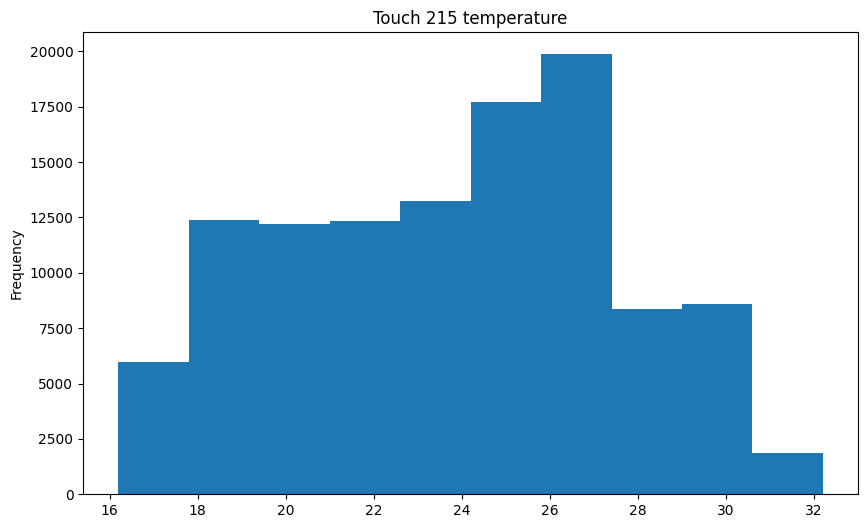

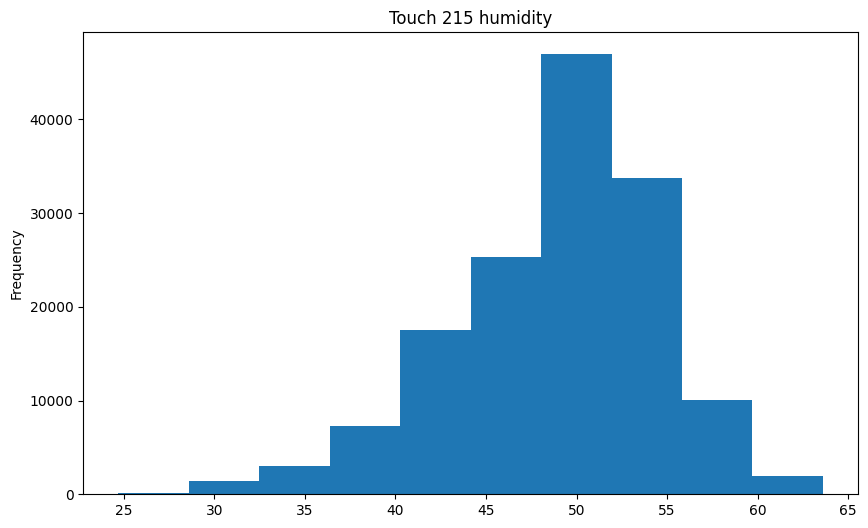

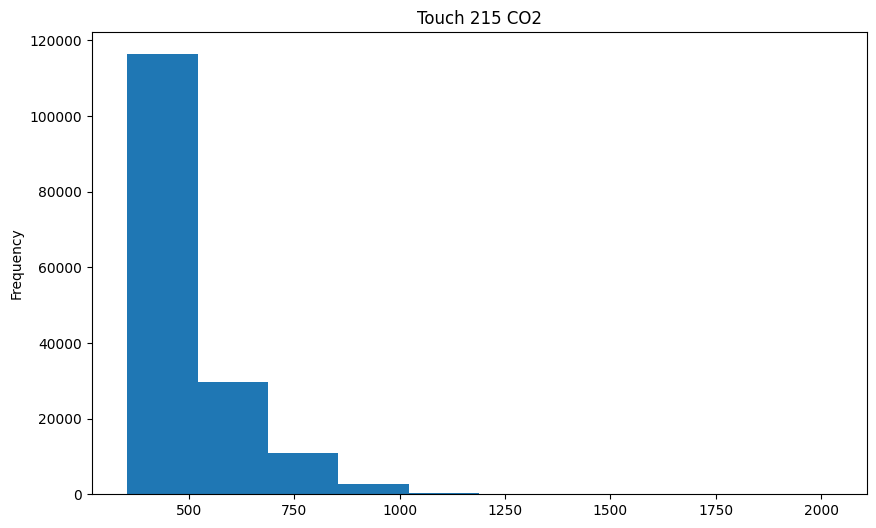

In [8]:
plot_data(df_temperature, 'temperature')
plot_data(df_humidity, 'humidity')
plot_data(df_co2, 'CO2')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_humidity, 'humidity')
plot_day_data(df_co2, 'CO2')
plot_hist(df_temperature, 'temperature')
plot_hist(df_humidity, 'humidity')
plot_hist(df_co2, 'CO2')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [9]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [10]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_humidity = reduce_df(df_humidity, '2023-03-01', '2023-05-15')
reduced_df_co2 = reduce_df(df_co2, '2023-03-01', '2023-05-15')

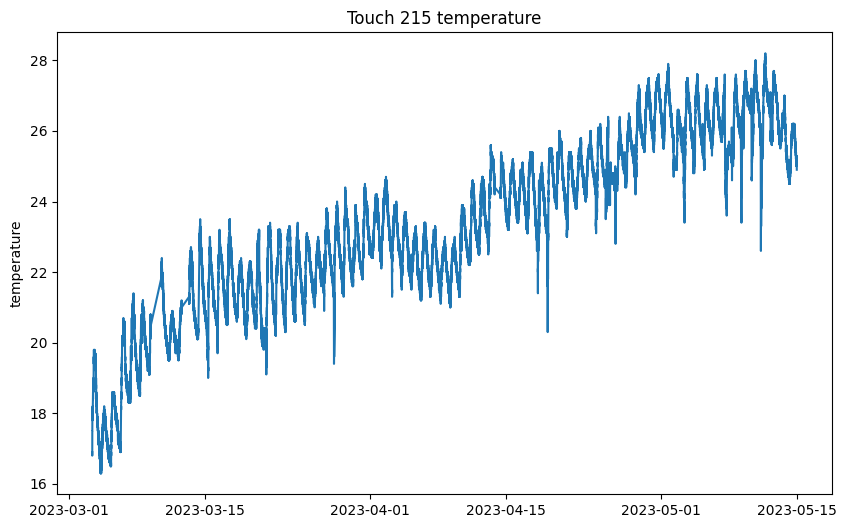

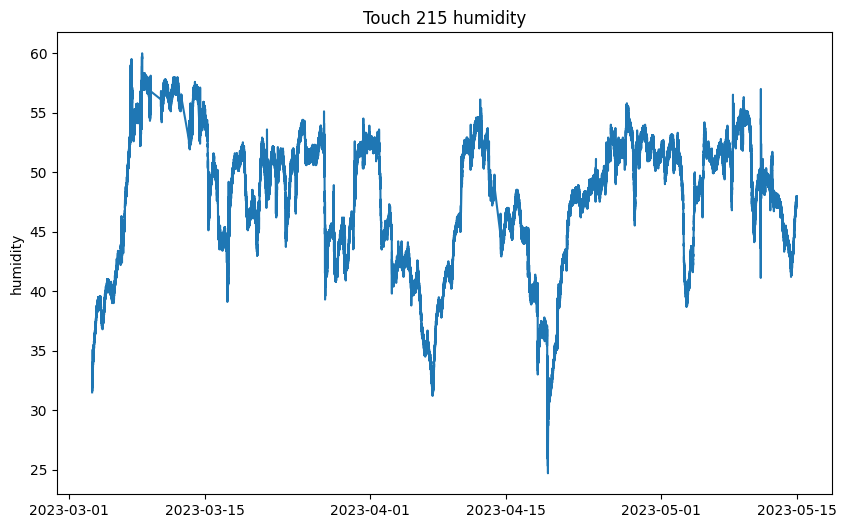

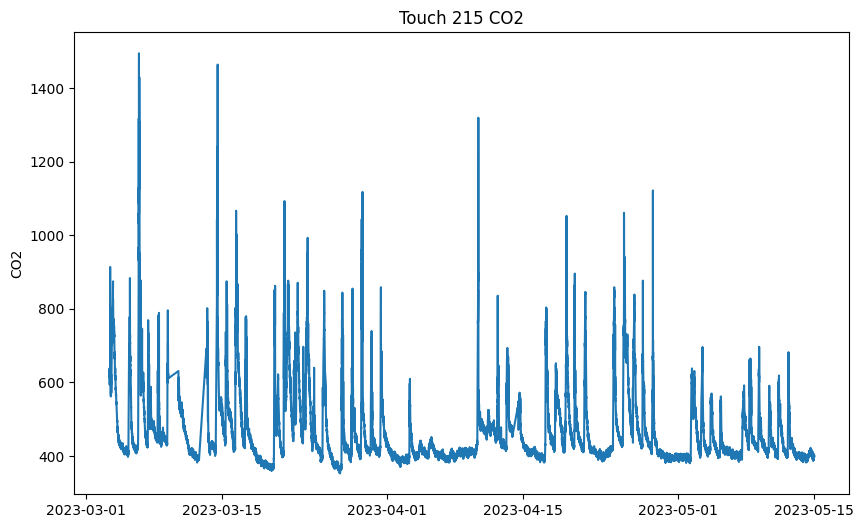

In [11]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_humidity, 'humidity')
plot_data(reduced_df_co2, 'CO2')

Registros duplicados

In [12]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [13]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_humidity = delete_duplicates(reduced_df_humidity, 'humidity')
reduced_df_co2 = delete_duplicates(reduced_df_co2, 'CO2')

temperature - Número de registros duplicados: 292
temperature - Número de registros tras eliminar duplicados:54121
humidity - Número de registros duplicados: 475
humidity - Número de registros tras eliminar duplicados:71319
CO2 - Número de registros duplicados: 530
CO2 - Número de registros tras eliminar duplicados:77383


In [14]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [15]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_humidity = fill_gaps_df(reduced_df_humidity, 'humidity')
reduced_df_co2 = fill_gaps_df(reduced_df_co2, 'CO2')

temperature - Original data:  54121 rows
temperature - Updated data:  104550 rows
humidity - Original data:  71319 rows
humidity - Updated data:  104550 rows
CO2 - Original data:  77383 rows
CO2 - Updated data:  104551 rows


In [16]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:31:00,16.90
2023-03-03 09:32:00,16.80
2023-03-03 09:33:00,16.85
2023-03-03 09:34:00,16.90
2023-03-03 09:35:00,16.95
...,...
2023-05-14 23:56:00,24.95
2023-05-14 23:57:00,24.90
2023-05-14 23:58:00,25.00


In [17]:
reduced_df_co2

,CO2
timestamp,
2023-03-03 09:30:00,615.04
2023-03-03 09:31:00,613.12
2023-03-03 09:32:00,616.96
2023-03-03 09:33:00,624.00
2023-03-03 09:34:00,624.96
...,...
2023-05-14 23:56:00,400.00
2023-05-14 23:57:00,400.96
2023-05-14 23:58:00,402.88


In [18]:
reduced_df_humidity

,humidity
timestamp,
2023-03-03 09:31:00,31.5
2023-03-03 09:32:00,31.6
2023-03-03 09:33:00,31.7
2023-03-03 09:34:00,32.1
2023-03-03 09:35:00,31.9
...,...
2023-05-14 23:56:00,47.9
2023-05-14 23:57:00,48.0
2023-05-14 23:58:00,47.8


Definimos datos de inicio y fin ignorando primer y último dia

In [19]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_humidity = reduced_df_humidity[(reduced_df_humidity.index >= '2023-03-06') & (reduced_df_humidity.index <= '2023-05-14')]
reduced_df_co2 = reduced_df_co2[(reduced_df_co2.index >= '2023-03-06') & (reduced_df_co2.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_humidity), len(reduced_df_co2)

(99361, 99361, 99361)

Normalizamos los datos

In [20]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [21]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_humidity, scaler_humidity = normalize_df(reduced_df_humidity)
reduced_df_co2, scaler_co2 = normalize_df(reduced_df_co2)

Por último, combinamos todos los datos en una misma tabla

In [22]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature,  reduced_df_humidity, reduced_df_co2], axis=1)
completed_df

,temperature,humidity,CO2
timestamp,,,
2023-03-06 00:00:00,0.070796,0.490652,0.060521
2023-03-06 00:01:00,0.064159,0.496884,0.061362
2023-03-06 00:02:00,0.057522,0.503116,0.060521
2023-03-06 00:03:00,0.064159,0.496601,0.058840
2023-03-06 00:04:00,0.070796,0.490085,0.056879
...,...,...,...
2023-05-13 23:56:00,0.743363,0.544476,0.039087
2023-05-13 23:57:00,0.734513,0.550142,0.038666
2023-05-13 23:58:00,0.730088,0.552408,0.037826


## Normalización de los valores + añadir periodicidad

In [23]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / day))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / day))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,humidity,CO2,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,
2023-03-06 00:00:00,0.070796,0.490652,0.060521,-1.267246e-11,1.000000,0.892796,0.450461
2023-03-06 00:01:00,0.064159,0.496884,0.061362,4.363309e-03,0.999990,0.892802,0.450450
2023-03-06 00:02:00,0.057522,0.503116,0.060521,8.726535e-03,0.999962,0.892807,0.450439
2023-03-06 00:03:00,0.064159,0.496601,0.058840,1.308960e-02,0.999914,0.892812,0.450429
2023-03-06 00:04:00,0.070796,0.490085,0.056879,1.745241e-02,0.999848,0.892818,0.450418
...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.743363,0.544476,0.039087,-1.745241e-02,0.999848,0.752028,-0.659131
2023-05-13 23:57:00,0.734513,0.550142,0.038666,-1.308960e-02,0.999914,0.752020,-0.659140
2023-05-13 23:58:00,0.730088,0.552408,0.037826,-8.726536e-03,0.999962,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [25]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [26]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 7), (99286, 45))

In [27]:
X

array([[[ 0.07079646,  0.49065156,  0.06052115, ...,  1.        ,
          0.89279631,  0.4504606 ],
        [ 0.06415929,  0.49688385,  0.06136173, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.05752212,  0.50311615,  0.06052115, ...,  0.99996192,
          0.89280707,  0.45043927],
        ...,
        [ 0.04129794,  0.51161473,  0.05771925, ...,  0.96923091,
          0.89310284,  0.44985256],
        [ 0.03834808,  0.51048159,  0.05603811, ...,  0.96814764,
          0.89310821,  0.44984189],
        [ 0.03539823,  0.51303116,  0.05351639, ...,  0.96704594,
          0.89311358,  0.44983122]],

       [[ 0.06415929,  0.49688385,  0.06136173, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.05752212,  0.50311615,  0.06052115, ...,  0.99996192,
          0.89280707,  0.45043927],
        [ 0.06415929,  0.49660057,  0.05884001, ...,  0.99991433,
          0.89281245,  0.45042861],
        ...,
        [ 0.03834808,  0.51048159,  0.05603811, ...,  

In [28]:
y

array([[0.04424779, 0.51558074, 0.05379658, ..., 0.04045512, 0.5108593 ,
        0.05435696],
       [0.05309735, 0.50141643, 0.05407677, ..., 0.0391909 , 0.50897073,
        0.05351639],
       [0.05014749, 0.49915014, 0.05435696, ..., 0.03792668, 0.50708215,
        0.05603811],
       ...,
       [0.72713864, 0.55807365, 0.03670496, ..., 0.73451327, 0.55014164,
        0.03866629],
       [0.72566372, 0.56147309, 0.03782572, ..., 0.7300885 , 0.55240793,
        0.03782572],
       [0.73451327, 0.55240793, 0.03670496, ..., 0.72566372, 0.56147309,
        0.03586439]])

In [29]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [30]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │         2,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,357 (83.43 KB)

 Trainable params: 21,357 (83.43 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
modelPath = '../LSMTTensorflow/bestModelTouch215.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [32]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0162 - mean_absolute_error: 0.0589 - root_mean_squared_error: 0.1084 - val_loss: 5.6176e-04 - val_mean_absolute_error: 0.0174 - val_root_mean_squared_error: 0.0237
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 2.3898e-04 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0155 - val_loss: 3.7896e-04 - val_mean_absolute_error: 0.0131 - val_root_mean_squared_error: 0.0195
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 2.0987e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0145 - val_loss: 3.0594e-04 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0175
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 1.9330e-04 - mean_absolute_error: 0.0084 - root_mean_squared_error: 0.0139 - val_loss: 3.0450e-04 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0174
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 1.85

In [33]:
HandMadeLSTM = load_model(modelPath)

In [34]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


(19858, 45)

In [35]:
y_test

array([[0.77433628, 0.78470255, 0.03474363, ..., 0.76814159, 0.78810198,
        0.03292239],
       [0.7699115 , 0.79603399, 0.03502382, ..., 0.76460177, 0.78470255,
        0.0325021 ],
       [0.77433628, 0.80169972, 0.03418324, ..., 0.76106195, 0.80509915,
        0.03334267],
       ...,
       [0.72713864, 0.55807365, 0.03670496, ..., 0.73451327, 0.55014164,
        0.03866629],
       [0.72566372, 0.56147309, 0.03782572, ..., 0.7300885 , 0.55240793,
        0.03782572],
       [0.73451327, 0.55240793, 0.03670496, ..., 0.72566372, 0.56147309,
        0.03586439]])

In [36]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::3]).flatten()
    test_predictions_humidity = scaler_humidity.inverse_transform(predictions[:, 1::3]).flatten()
    test_predictions_co2 = scaler_co2.inverse_transform(predictions[:, 2::3]).flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::3]).flatten()
    y_test_humidity = scaler_humidity.inverse_transform(test[:, 1::3]).flatten()
    y_test_co2 = scaler_co2.inverse_transform(test[:, 2::3]).flatten()
    
    return test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2

test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(test_predictions, y_test)

In [37]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Touch 215 ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:1440], label='True')
    plt.plot(test_predictions[:1440], label='Predicted')
    plt.title('Touch 215 ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

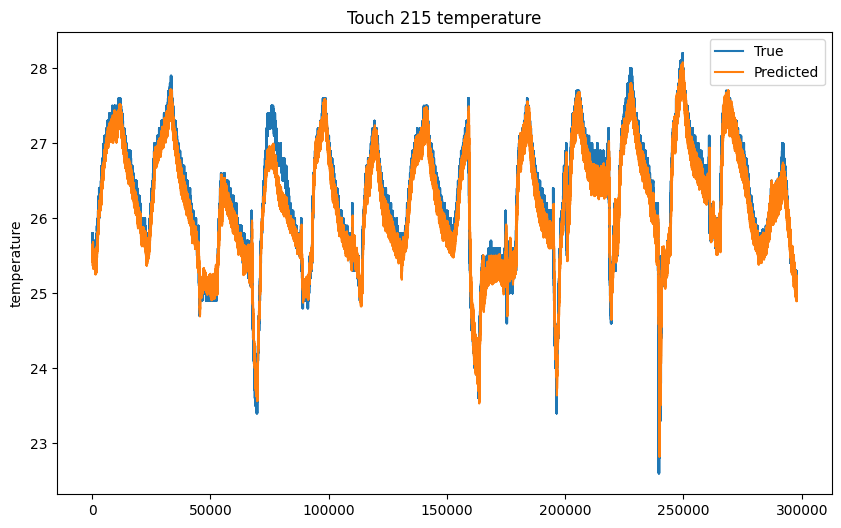

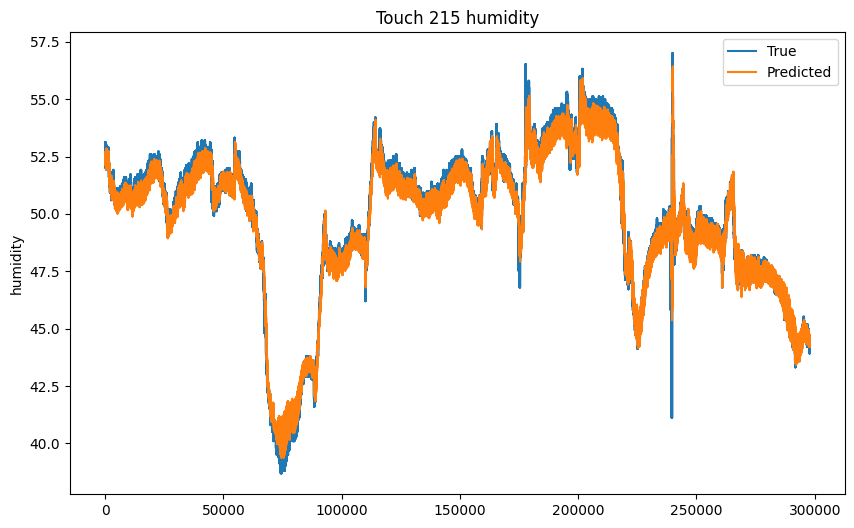

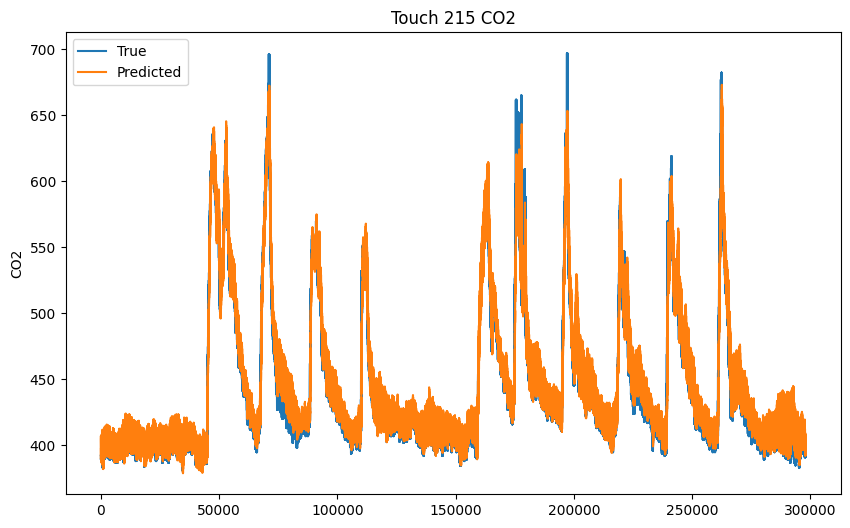

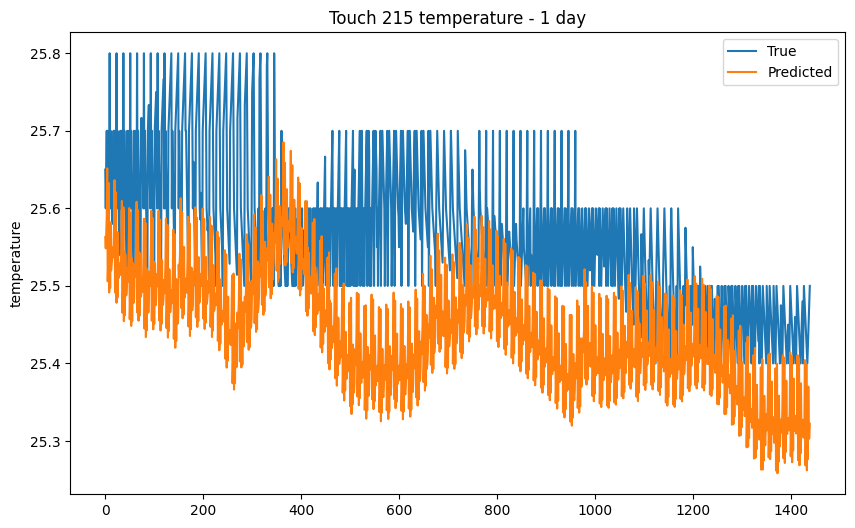

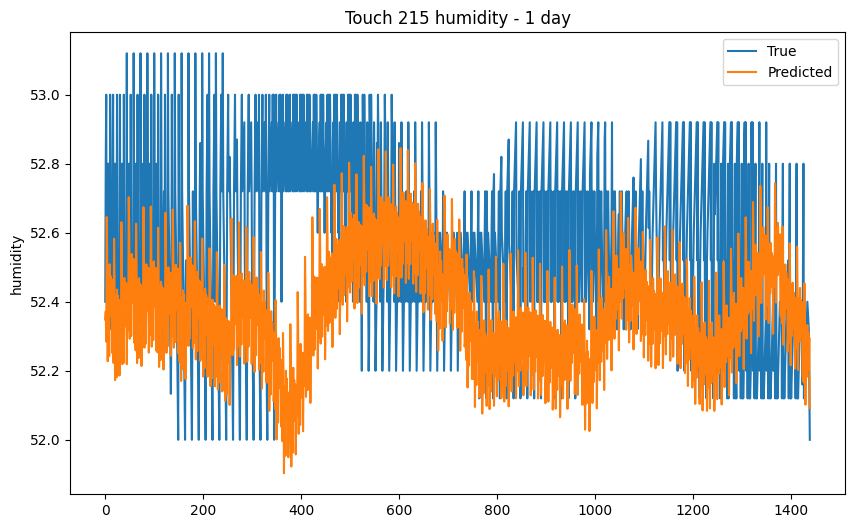

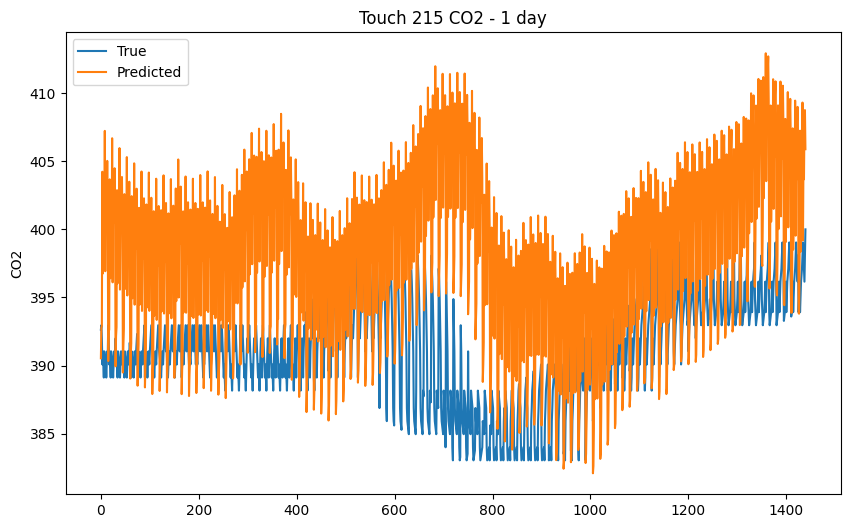

In [38]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')

In [39]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')

temperature - MSE: 0.049042960173489164
temperature - MAE: 0.17979923007544343
temperature - RMSE: 0.2214564520927064
humidity - MSE: 0.28275946928517615
humidity - MAE: 0.38732816827857586
humidity - RMSE: 0.5317513227864846
CO2 - MSE: 169.59026475833056
CO2 - MAE: 9.879182806372588
CO2 - RMSE: 13.022682702052238


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [40]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0286 - mean_absolute_error: 0.0880 - root_mean_squared_error: 0.1492 - val_loss: 8.5941e-04 - val_mean_absolute_error: 0.0183 - val_root_mean_squared_error: 0.0293
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 4.8674e-04 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0221 - val_loss: 7.7292e-04 - val_mean_absolute_error: 0.0171 - val_root_mean_squared_error: 0.0278
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - loss: 4.6313e-04 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0215 - val_loss: 8.3135e-04 - val_mean_absolute_error: 0.0194 - val_root_mean_squared_error: 0.0288
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - loss: 4.4350e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0211 - val_loss: 8.1263e-04 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0285
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.3344e-

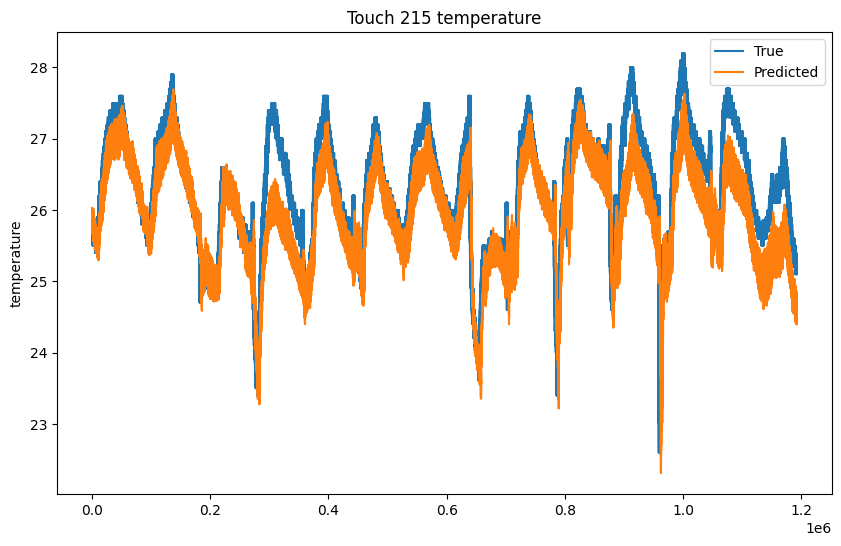

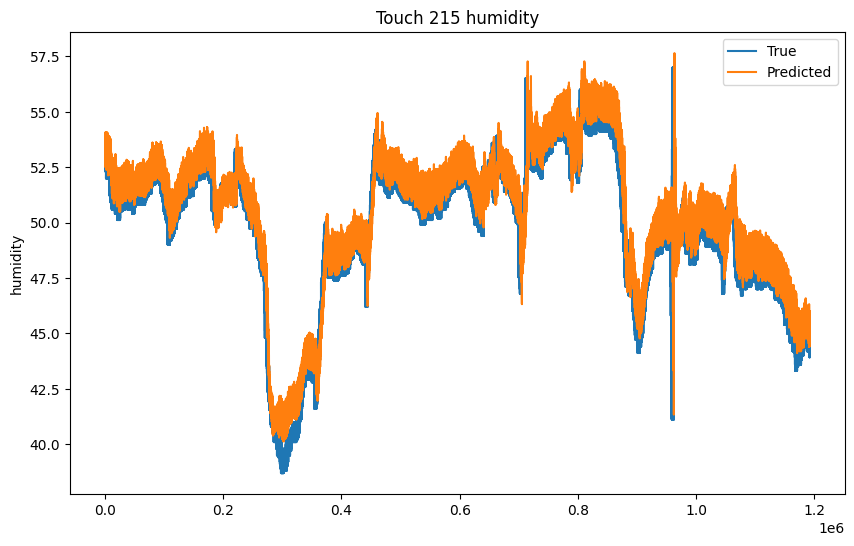

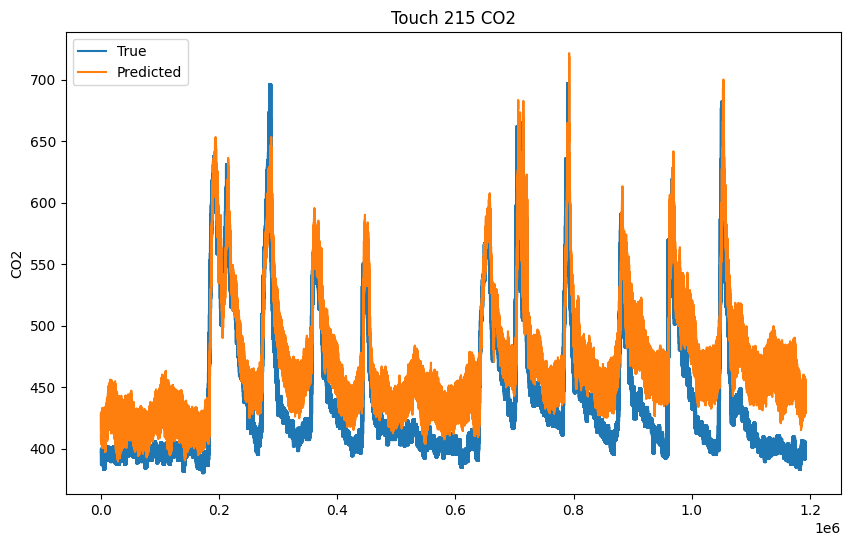

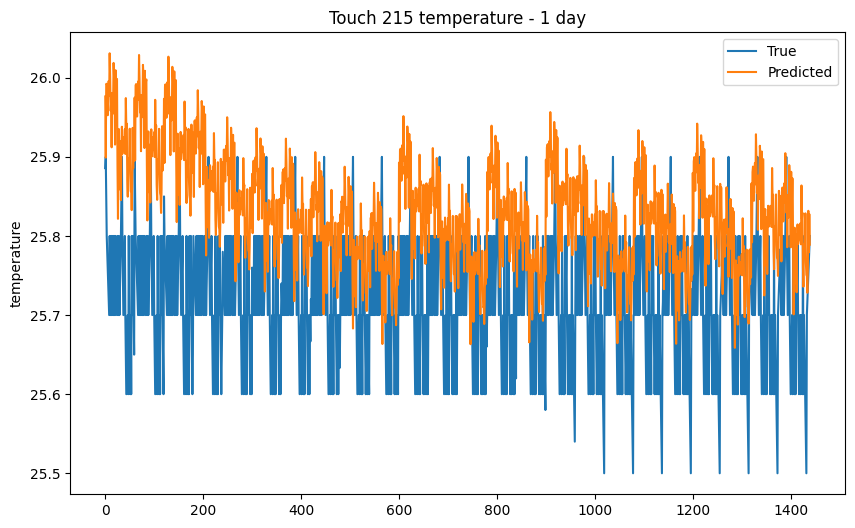

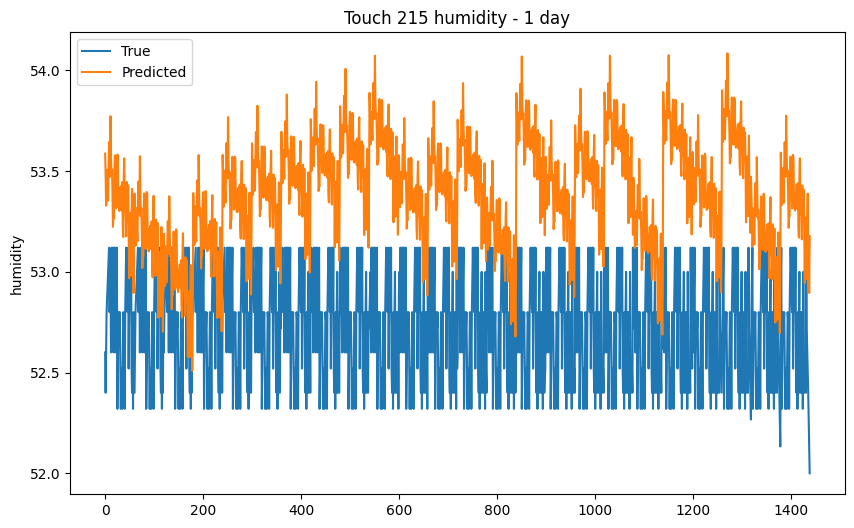

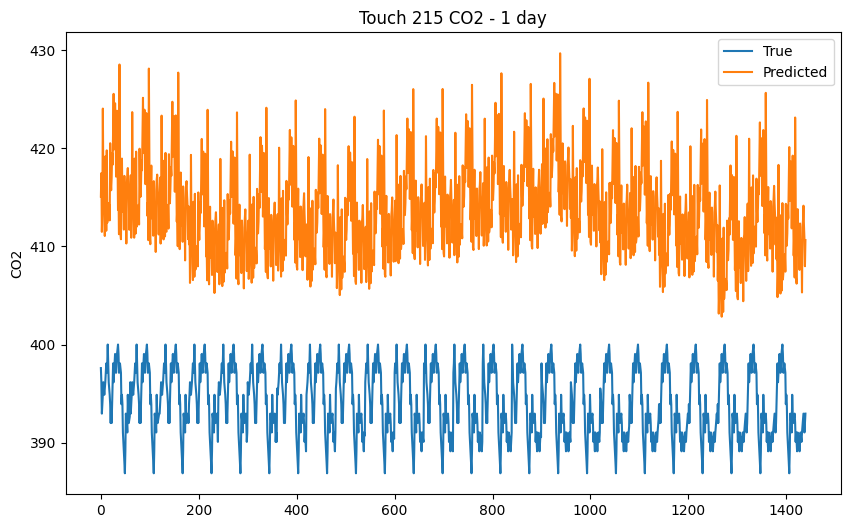

temperature - MSE: 0.25165148265871956
temperature - MAE: 0.39328327379068534
temperature - RMSE: 0.5016487642352162
humidity - MSE: 1.0359965347940456
humidity - MAE: 0.8416853597117134
humidity - RMSE: 1.0178391497648562
CO2 - MSE: 1465.569242774541
CO2 - MAE: 34.176028145992696
CO2 - RMSE: 38.282753855679466
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.0952 - root_mean_squared_error: 0.1541 - val_loss: 0.0028 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0532
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0443 - val_loss: 0.0027 - val_mean_absolute_error: 0.0329 - val_root_mean_squared_error: 0.0524
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0018 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0425 - val_loss: 0.0028 - val_mean_absolute_error: 0.0348 - val_root_mean_squared_error: 0.0529
Epoch 4/20
1986

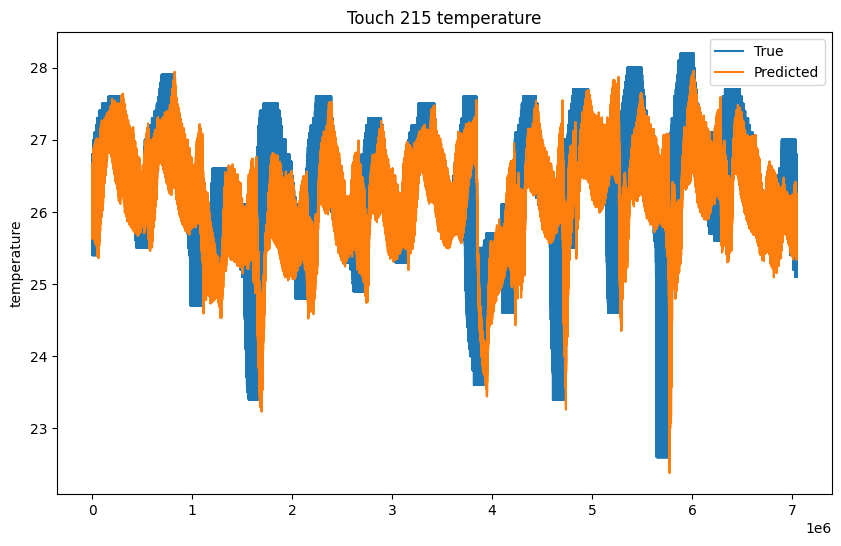

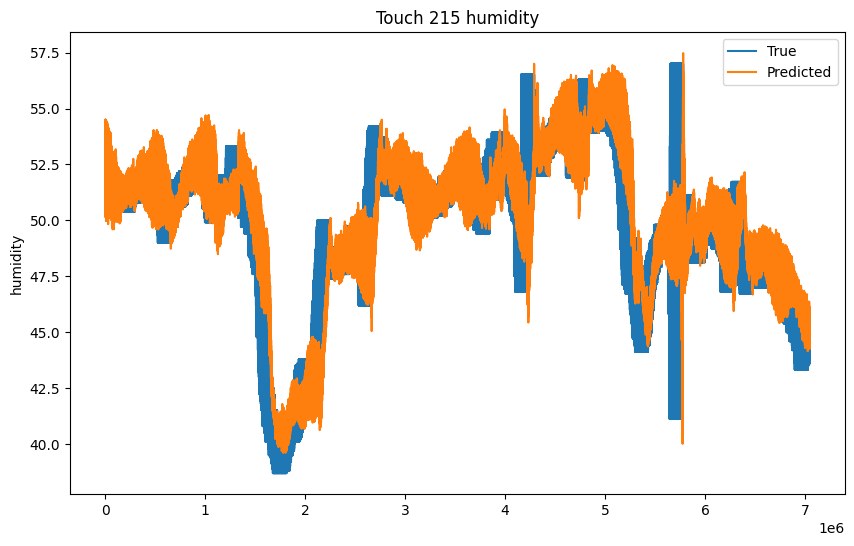

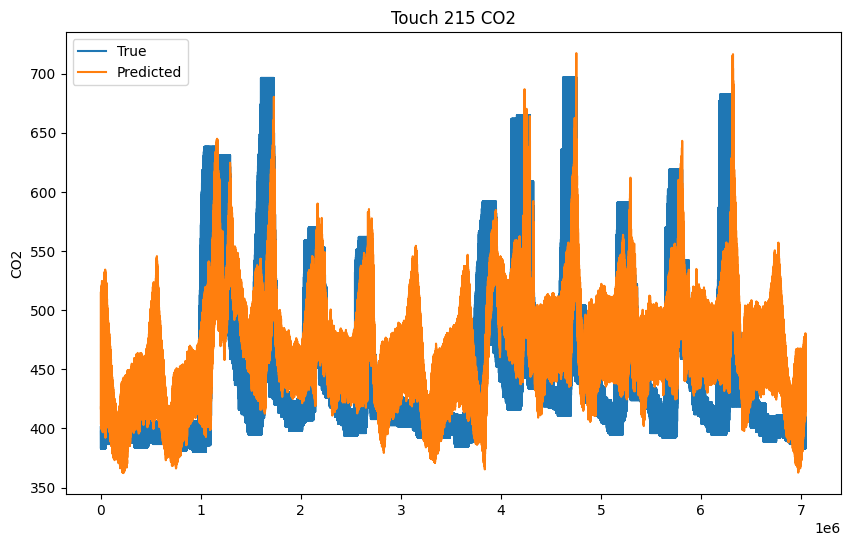

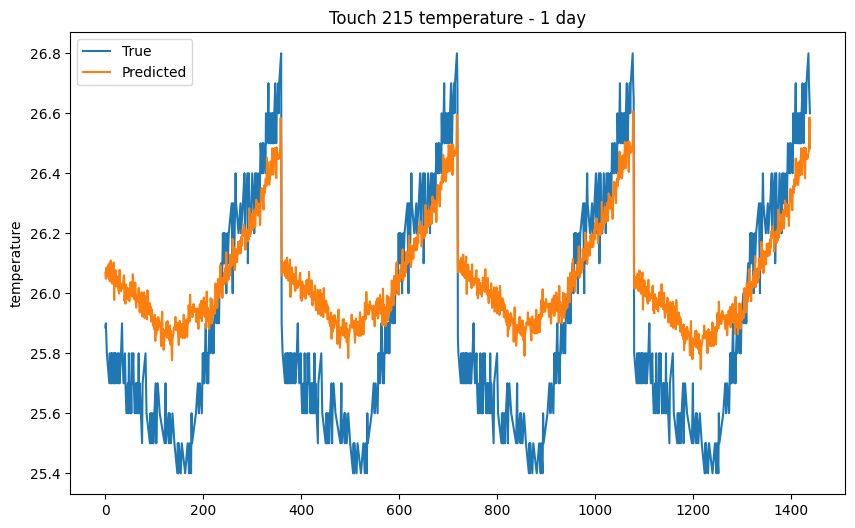

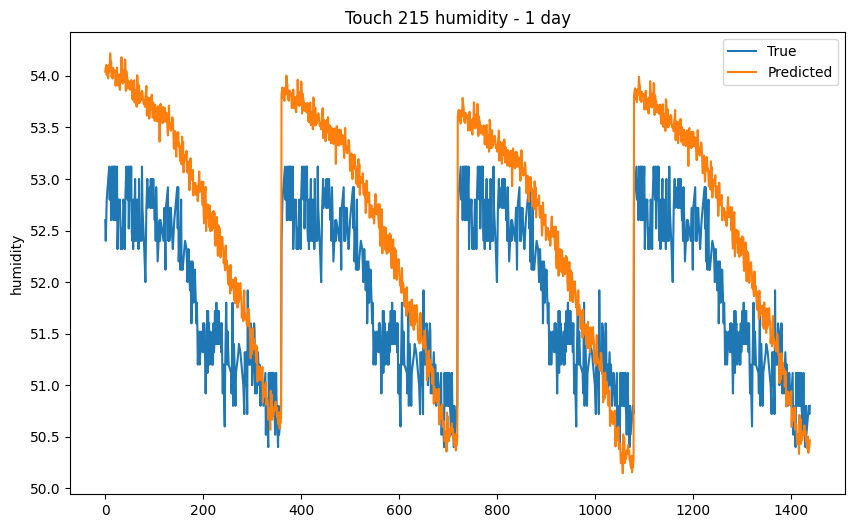

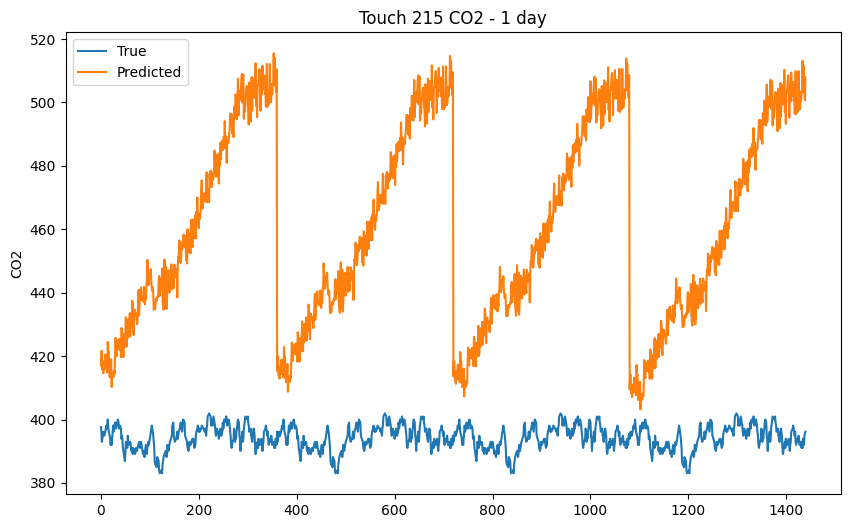

temperature - MSE: 0.4710173137187442
temperature - MAE: 0.4588833613696953
temperature - RMSE: 0.68630701127028
humidity - MSE: 2.3564506705086017
humidity - MAE: 1.1079933798341617
humidity - RMSE: 1.5350735065489867
CO2 - MSE: 2743.5500580984044
CO2 - MAE: 43.79911386826561
CO2 - RMSE: 52.378908523358945
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.1015 - root_mean_squared_error: 0.1589 - val_loss: 0.0048 - val_mean_absolute_error: 0.0456 - val_root_mean_squared_error: 0.0690
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0353 - root_mean_squared_error: 0.0542 - val_loss: 0.0047 - val_mean_absolute_error: 0.0453 - val_root_mean_squared_error: 0.0684
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0527 - val_loss: 0.0043 - val_mean_absolute_error: 0.0455 - val_root_mean_squared_error: 0.0654
Epoch 4/20
1986/198

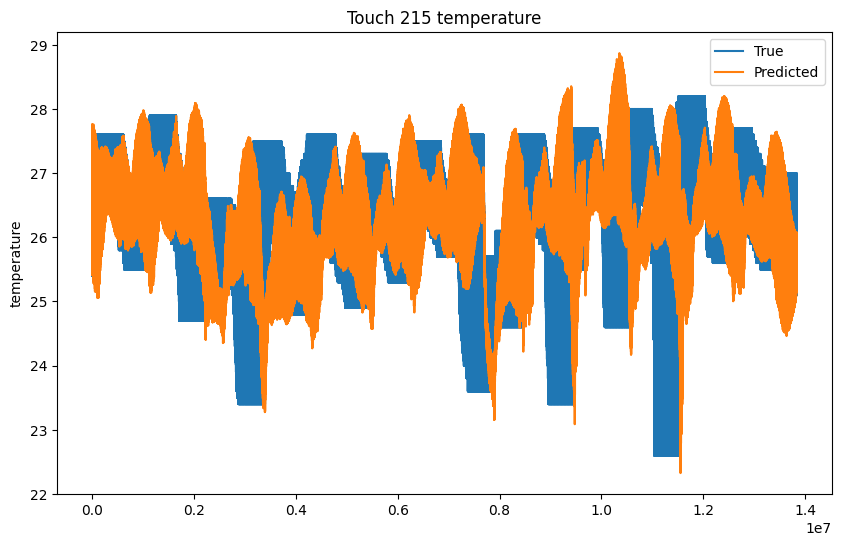

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


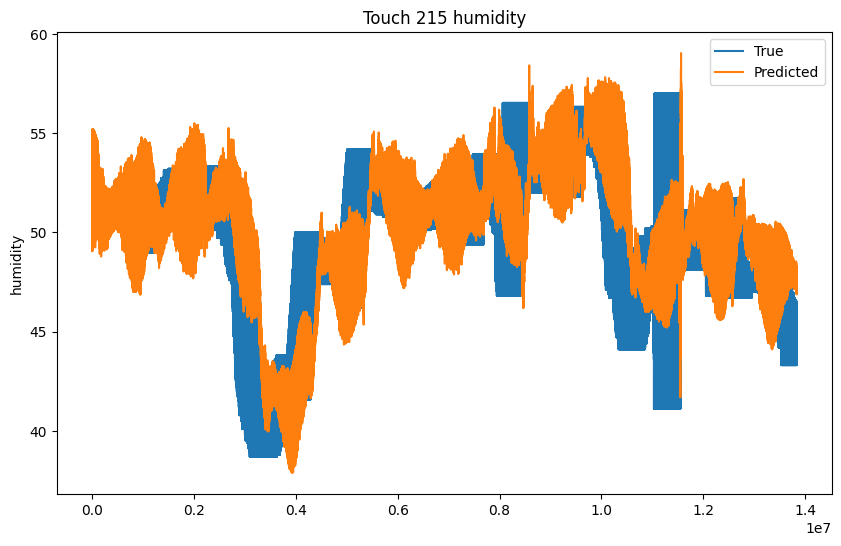

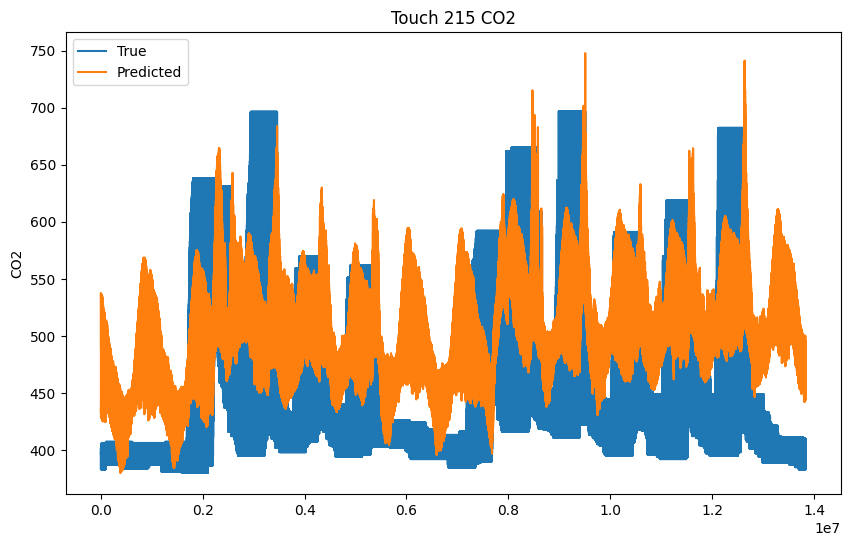

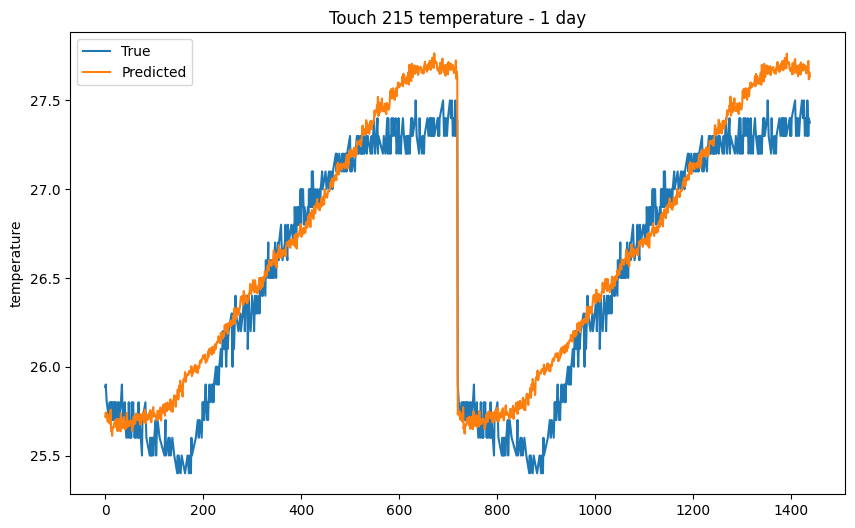

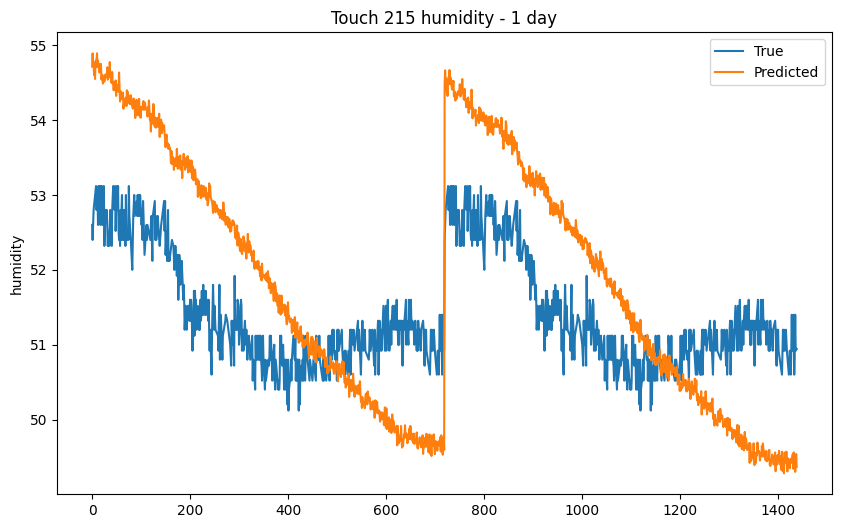

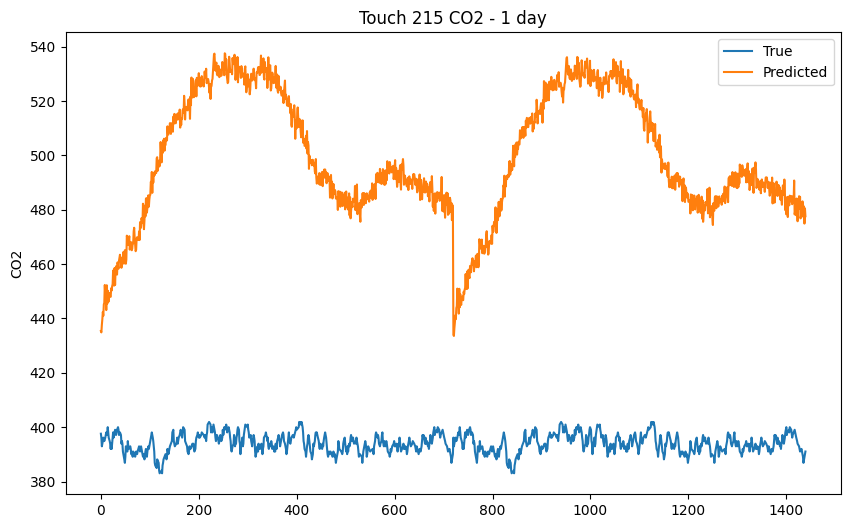

temperature - MSE: 0.7747207334894359
temperature - MAE: 0.6355897951036847
temperature - RMSE: 0.8801822160720109
humidity - MSE: 5.302917552875654
humidity - MAE: 1.7624200278121482
humidity - RMSE: 2.3028064514577977
CO2 - MSE: 6580.503072904709
CO2 - MAE: 72.37160902397011
CO2 - RMSE: 81.12030000502162


In [41]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_touch_215_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')
    
    

In [42]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/touch/scaler_temperature_touch_215.pkl', 'wb'))
dump(scaler_humidity, open('scalers/touch/scaler_humidity_touch_215.pkl', 'wb'))
dump(scaler_co2, open('scalers/touch/scaler_co2_touch_215.pkl', 'wb'))


In [43]:
scaler_temperature.data_max_, scaler_humidity.data_max_, scaler_co2.data_max_, scaler_temperature.data_min_, scaler_humidity.data_min_, scaler_co2.data_min_

(array([28.2]),
 array([60.]),
 array([1495.04]),
 array([16.9]),
 array([24.7]),
 array([352.96]))